In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [11]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


In [12]:
# Load images and labels
images = []
labels = []
dataset_path = '/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data'
for subfolder in tqdm(os.listdir(dataset_path)):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

df = pd.DataFrame({'image': images, 'label': labels})


100%|██████████| 2/2 [00:00<00:00, 164.56it/s]


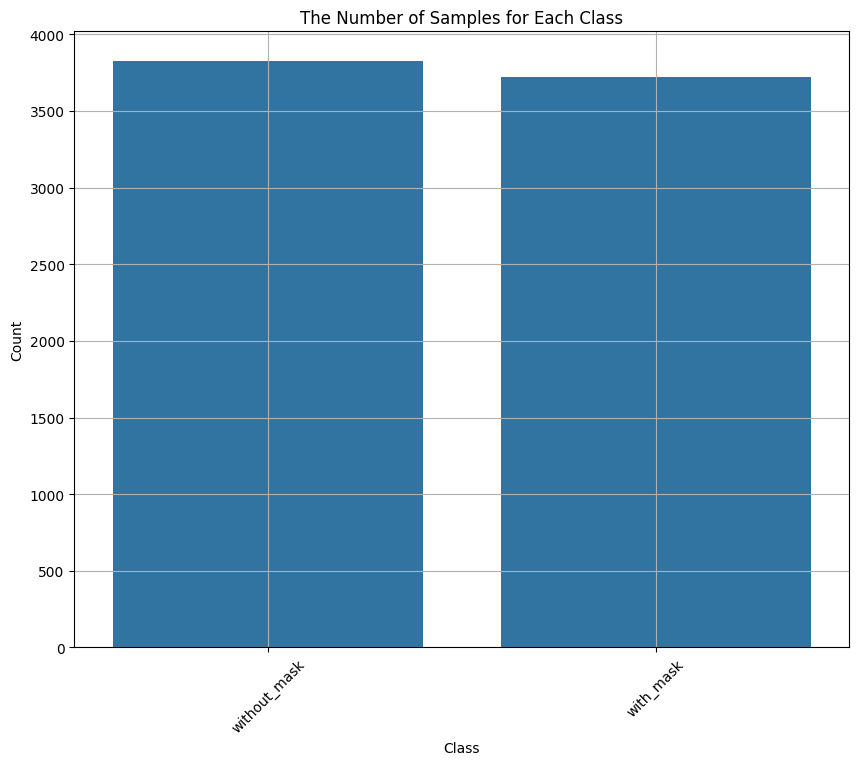

In [13]:
# Visualize class distribution
plt.figure(figsize=(10, 8))
ax = sns.countplot(x=df.label)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.title('The Number of Samples for Each Class')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

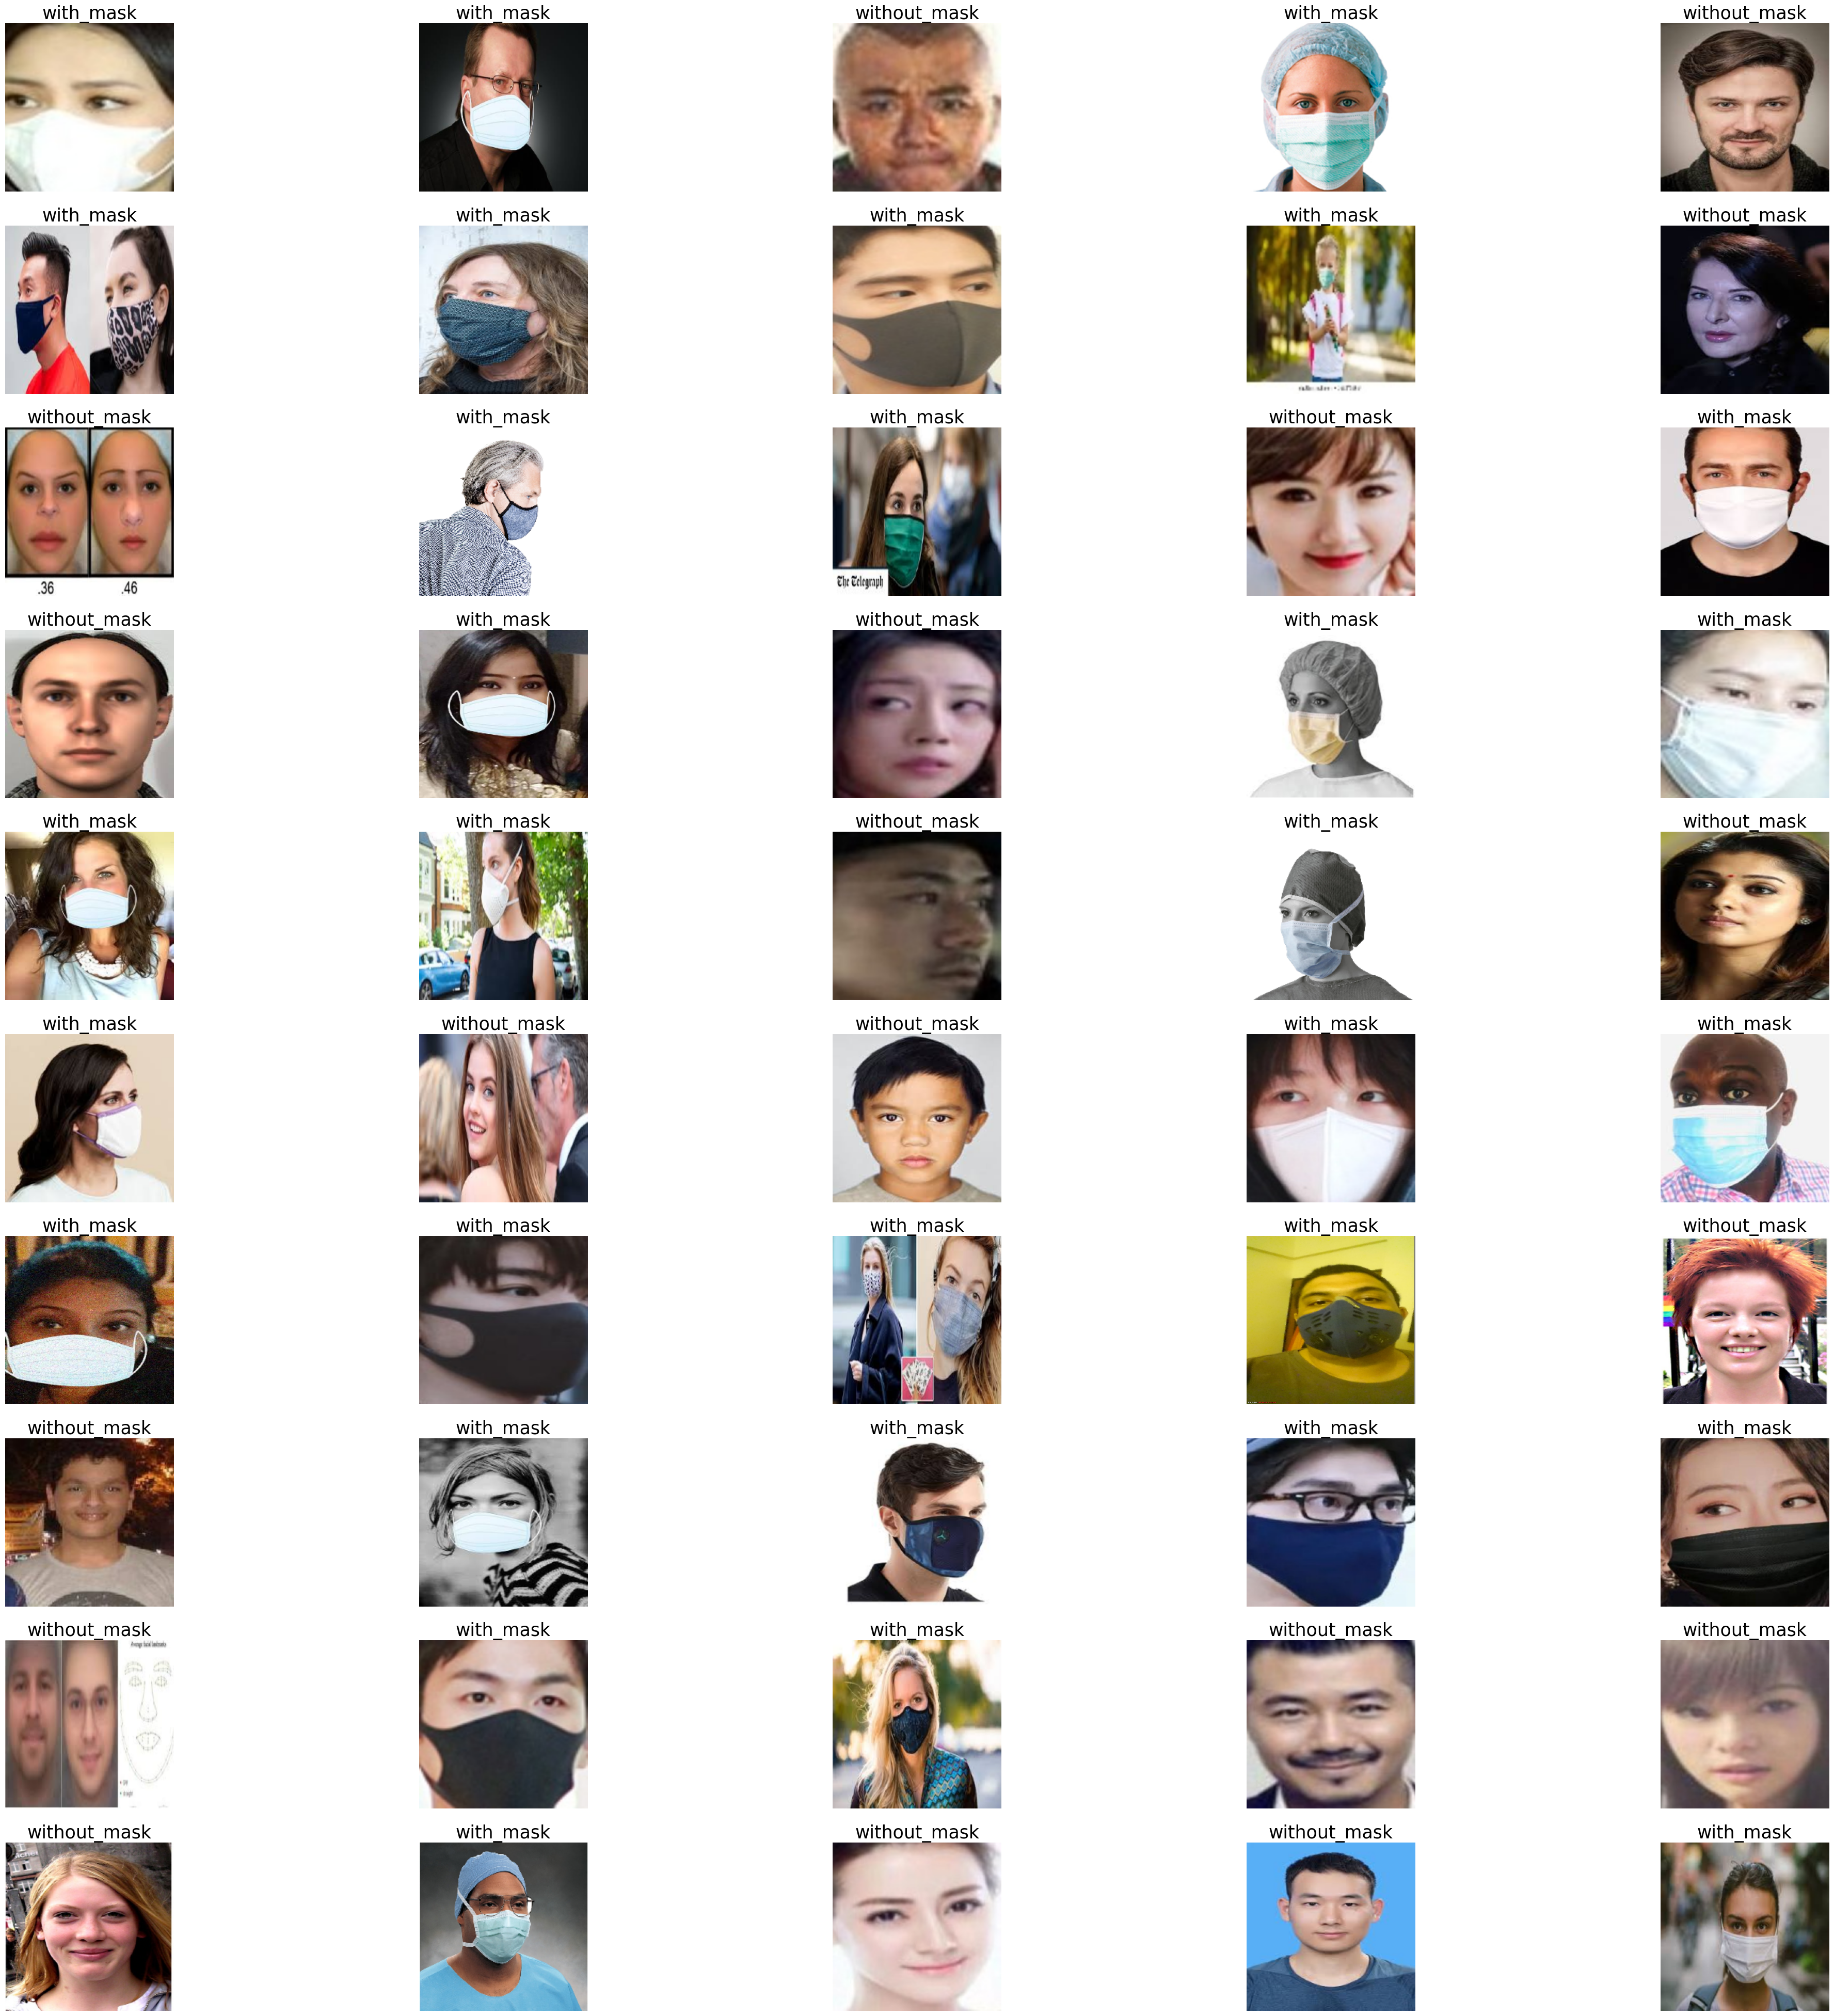

In [14]:
# Show sample images
plt.figure(figsize=(50, 50))
for n, i in enumerate(np.random.randint(0, len(df), 50)):
    plt.subplot(10, 5, n + 1)
    img = cv2.imread(df.image[i])
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i], fontsize=25)
plt.show()

In [15]:
# Train-test-validation split
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42, shuffle=True, stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, shuffle=True, stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [16]:
# Data generators
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 5287 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.


In [17]:
# Build Stacked CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Assuming binary classification
])

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training with callbacks
checkpoint_cb = ModelCheckpoint("stacked_cnn_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, early_stopping_cb]
)


Epoch 1/10
141/166 [========================>.....] - ETA: 11s - loss: 0.5301 - accuracy: 0.7859

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 [==============================] - ETA: 0s - loss: 0.4988 - accuracy: 0.7978

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 79s 472ms/step - loss: 0.4988 - accuracy: 0.7978 - val_loss: 0.3350 - val_accuracy: 0.8553
Epoch 2/10
166/166 [==============================] - 79s 476ms/step - loss: 0.2544 - accuracy: 0.8933 - val_loss: 0.2608 - val_accuracy: 0.9029
Epoch 3/10
166/166 [==============================] - 79s 475ms/step - loss: 0.2021 - accuracy: 0.9236 - val_loss: 0.2074 - val_accuracy: 0.9197
Epoch 4/10
166/166 [==============================] - 79s 477ms/step - loss: 0.1597 - accuracy: 0.9391 - val_loss: 0.1701 - val_accuracy: 0.9373
Epoch 5/10
166/166 [==============================] - 79s 475ms/step - loss: 0.1147 - accuracy: 0.9610 - val_loss: 0.2020 - val_accuracy: 0.9320
Epoch 6/10
166/166 [==============================] - 78s 472ms/step - loss: 0.0861 - accuracy: 0.9714 - val_loss: 0.2597 - val_accuracy: 0.9259
Epoch 7/10
166/166 [==============================] - 79s 475ms/step - loss: 0.0768 - accuracy: 0.9735 - val_loss: 0.2207 - val_accuracy: 0.9

Text(0.5, 1.0, 'Training and Validation Loss')

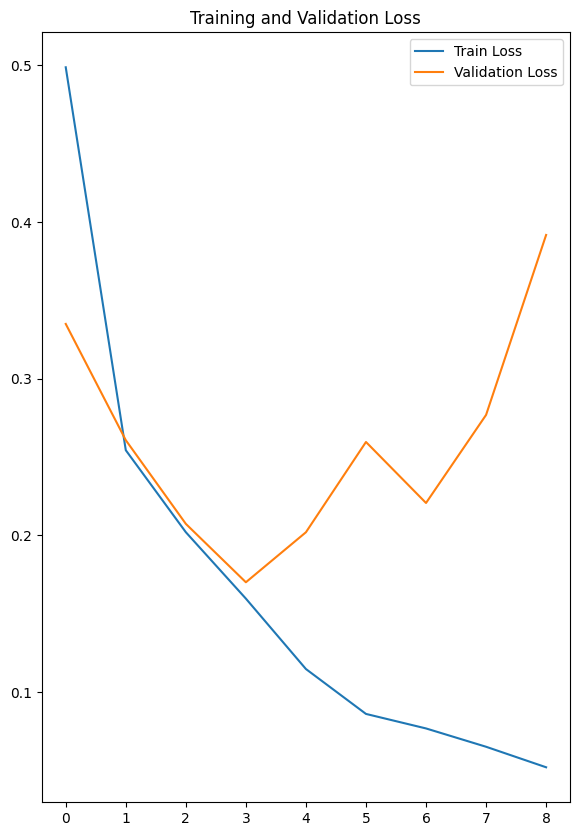

In [19]:
# Plot training history
hist_df = pd.DataFrame(hist.history)
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

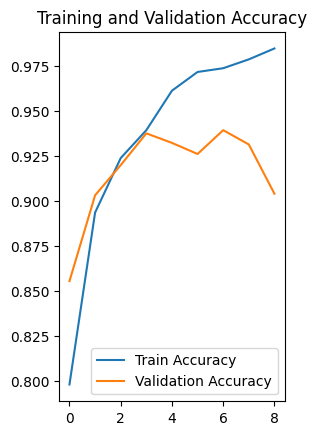

In [20]:
plt.subplot(1, 2, 2)
plt.plot(hist_df['accuracy'], label='Train Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [21]:
# Evaluate on test data
score, acc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)


36/36 [==============================] - 3s 90ms/step - loss: 0.1836 - accuracy: 0.9400
Test Loss = 0.18356604874134064
Test Accuracy = 0.9399823546409607


In [22]:
# Predictions and Confusion Matrix
y_test = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

36/36 [==============================] - 3s 87ms/step


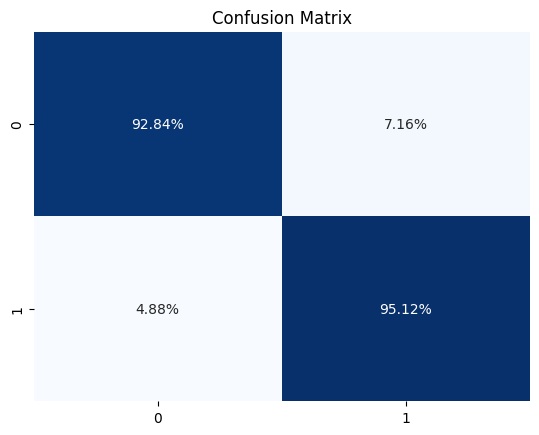

In [23]:
# Plot Confusion Matrix
CM = confusion_matrix(y_test, y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Classification Report
class_names = ['with_mask', 'without_mask']  # Adjust class names as needed
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
               precision    recall  f1-score   support

   with_mask       0.95      0.93      0.94       559
without_mask       0.93      0.95      0.94       574

    accuracy                           0.94      1133
   macro avg       0.94      0.94      0.94      1133
weighted avg       0.94      0.94      0.94      1133

